In [1]:
# 2021/09/16 업데이트 내용
# 더 이상 폴더 생성시 연립다세대_오피스텔 입력하지 않아도 됨

In [2]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [3]:
target_gu = '금천구' # 구 명
target_dong = '' # 동 명: 동 명에서 마지막 글자 '동' 뺄 것
#target_purpose = '준주거' # 종 명: 건드릴 필요 없음
target_building_age = 5 # 건물연식: 건드릴 필요 없음
target_period = 36 # 계약날짜 검색범위: 건드릴 필요 없음
target_starting_year = 2018 # 검색 시작 계약 년도: 건드릴 필요 없음

In [4]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [5]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20211016'

In [6]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [7]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [8]:
def data_prep(bdtype, tradetype, starting_year=2018):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    if (tradetype != '매매') & (tradetype != '전월세'):
        raise ValueError('두번째 변수는 매매 또는 전월세만 입력 가능')
    
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        splitted_filename = f.split('실거래가_')       
        file_year = int(splitted_filename[-1][:4])
        
        if file_year < starting_year:
            continue
        
        try:
            df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        except:
            try:
                df = pd.read_csv(basedir + f, encoding='utf-8', header=15)
            except:
                df = pd.read_csv(basedir + f, header=15)
        
        if '건물명' in df.columns:
            df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
        elif '단지명' in df.columns:
            df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
            
        if '대지권면적(㎡)' in df.columns:
            df = df.drop(columns=['대지권면적(㎡)'])
                
            
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])
            
        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
    
    if tradetype == '전월세':
        concat_df = concat_df.rename(columns={'전월세구분':'거래구분', '보증금(만원)':'거래금액(만원)'})
        concat_df = concat_df.drop(columns=['월세(만원)'])
        concat_df = concat_df[concat_df['거래구분'] == '전세']
    elif tradetype == '매매':
        concat_df['거래구분'] = '매매'
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].astype('Int64')
    concat_df['계약일'] = concat_df['계약일'].astype('Int64')
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [9]:
apart_trade_df = data_prep('아파트', '매매')
apart_lease_df = data_prep('아파트', '전월세')
apart_df = pd.concat([apart_trade_df, apart_lease_df]).reset_index(drop=True)
del apart_trade_df, apart_lease_df
apart_df['부동산유형'] = '아파트'
print(apart_df.shape)
apart_df.head()

16it [00:00, 32.38it/s]
13it [00:00, 45.60it/s]c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
16it [00:01, 14.76it/s]


(740807, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 658-1,언주로 3,개포6차우성아파트1동~8동,79.97,130000,4,1987,매매,31,2018-01-03,1625.609604,34,아파트
1,서울특별시 강남구 개포동 658-1,언주로 3,개포6차우성아파트1동~8동,79.97,117000,2,1987,매매,31,2018-01-08,1463.048643,34,아파트
2,서울특별시 강남구 개포동 658-1,언주로 3,개포6차우성아파트1동~8동,79.97,130000,1,1987,매매,31,2018-01-11,1625.609604,34,아파트
3,서울특별시 강남구 개포동 658-1,언주로 3,개포6차우성아파트1동~8동,79.97,139500,2,1987,매매,31,2018-03-19,1744.404152,34,아파트
4,서울특별시 강남구 개포동 658-1,언주로 3,개포6차우성아파트1동~8동,54.98,107500,5,1987,매매,31,2018-04-05,1955.256457,34,아파트


In [10]:
house_df = pd.concat([apart_df]).sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
del apart_df
print(house_df.shape)
house_df.head()

(740807, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 1164-12,논현로2길 34,새롬(1164-12),73.50,42000,4,2000,전세,18,2018-10-10,571.428571,21,아파트
1,서울특별시 강남구 개포동 1164-12,논현로2길 34,새롬(1164-12),73.50,64000,4,2000,매매,20,2020-07-17,870.748299,21,아파트
2,서울특별시 강남구 개포동 1164-12,논현로2길 34,새롬(1164-12),73.50,55000,5,2000,전세,20,2020-10-14,748.299320,21,아파트
3,서울특별시 강남구 개포동 1164-13,논현로2길 36,새롬(1164-13),59.67,34000,2,2000,전세,18,2018-05-15,569.800570,21,아파트
4,서울특별시 강남구 개포동 1164-13,논현로2길 36,새롬(1164-13),59.67,34000,2,2000,전세,18,2018-05-15,569.800570,21,아파트


In [11]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [12]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [13]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [14]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [15]:
house_df['일괄계약'] = 'N'

In [16]:
#house_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [17]:
'''print(house_df.shape)
house_df.head()'''

'print(house_df.shape)\nhouse_df.head()'

In [18]:
def identify_bulk_contract(df):
    df = df.copy()
    
    for addr in tqdm(df['지번주소'].unique()):
        addr_df = df[df['지번주소'] == addr]
        
        for btyear in addr_df['건축년도'].unique():
            btyear_df = addr_df[addr_df['건축년도'] == btyear]
        
            for contract_date in btyear_df['계약날짜'].unique():
                contract_date_df = btyear_df[btyear_df['계약날짜'] == contract_date]

                if contract_date_df.shape[0] >= 5:
                    df.loc[contract_date_df.index, '일괄계약'] = 'Y'
    
    return df

In [19]:
target_1_12_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=6)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_1_12_df.shape)
target_1_12_df.head()

(1204, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
222573,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,16,2021,전세,0,2021-08-12,1146.788991,0,아파트,금천구,가산동,N
222574,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,15,2021,전세,0,2021-08-28,1146.788991,0,아파트,금천구,가산동,N
222575,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,13,2021,전세,0,2021-08-13,1077.586207,0,아파트,금천구,가산동,N
222576,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,15,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N
222577,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,16,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N


In [20]:
target_2_24_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_2_24_df.shape)
target_2_24_df.head()

(2896, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
222573,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,16,2021,전세,0,2021-08-12,1146.788991,0,아파트,금천구,가산동,N
222574,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,15,2021,전세,0,2021-08-28,1146.788991,0,아파트,금천구,가산동,N
222575,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,13,2021,전세,0,2021-08-13,1077.586207,0,아파트,금천구,가산동,N
222576,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,15,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N
222577,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,16,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N


In [21]:
target_3_36_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=24)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_3_36_df.shape)
target_3_36_df.head()

(6340, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
222573,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,16,2021,전세,0,2021-08-12,1146.788991,0,아파트,금천구,가산동,N
222574,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,15,2021,전세,0,2021-08-28,1146.788991,0,아파트,금천구,가산동,N
222575,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,13,2021,전세,0,2021-08-13,1077.586207,0,아파트,금천구,가산동,N
222576,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,15,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N
222577,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,16,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N


In [22]:
target_5_60_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=36)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_5_60_df.shape)
target_5_60_df.head()

(9221, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
222573,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,16,2021,전세,0,2021-08-12,1146.788991,0,아파트,금천구,가산동,N
222574,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,15,2021,전세,0,2021-08-28,1146.788991,0,아파트,금천구,가산동,N
222575,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,13,2021,전세,0,2021-08-13,1077.586207,0,아파트,금천구,가산동,N
222576,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,15,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N
222577,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,16,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N


In [23]:
target_1_12_df = identify_bulk_contract(target_1_12_df)
print(target_1_12_df.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 297.52it/s]

(1204, 16)


In [24]:
target_2_24_df = identify_bulk_contract(target_2_24_df)
print(target_2_24_df.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 211.72it/s]

(2896, 16)


In [25]:
target_3_36_df = identify_bulk_contract(target_3_36_df)
print(target_3_36_df.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 166/166 [00:01<00:00, 113.60it/s]

(6340, 16)


In [26]:
target_5_60_df = identify_bulk_contract(target_5_60_df)
print(target_5_60_df.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:01<00:00, 89.49it/s]

(9221, 16)


In [27]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [28]:
print(sales_idx_df.shape)
sales_idx_df.head()

(1, 375)


,지 역,2006년 01월_지수,2006년 01월_변동률,2006년 02월_지수,2006년 02월_변동률,2006년 03월_지수,2006년 03월_변동률,2006년 04월_지수,2006년 04월_변동률,2006년 05월_지수,2006년 05월_변동률,2006년 06월_지수,2006년 06월_변동률,2006년 07월_지수,2006년 07월_변동률,2006년 08월_지수,2006년 08월_변동률,2006년 09월_지수,2006년 09월_변동률,2006년 10월_지수,2006년 10월_변동률,2006년 11월_지수,2006년 11월_변동률,2006년 12월_지수,2006년 12월_변동률,2007년 01월_지수,2007년 01월_변동률,2007년 02월_지수,2007년 02월_변동률,2007년 03월_지수,2007년 03월_변동률,2007년 04월_지수,2007년 04월_변동률,2007년 05월_지수,2007년 05월_변동률,2007년 06월_지수,2007년 06월_변동률,2007년 07월_지수,2007년 07월_변동률,2007년 08월_지수,2007년 08월_변동률,2007년 09월_지수,2007년 09월_변동률,2007년 10월_지수,2007년 10월_변동률,2007년 11월_지수,2007년 11월_변동률,2007년 12월_지수,2007년 12월_변동률,2008년 01월_지수,2008년 01월_변동률,2008년 02월_지수,2008년 02월_변동률,2008년 03월_지수,2008년 03월_변동률,2008년 04월_지수,2008년 04월_변동률,2008년 05월_지수,2008년 05월_변동률,2008년 06월_지수,2008년 06월_변동률,2008년 07월_지수,2008년 07월_변동률,2008년 08월_지수,2008년 08월_변동률,2008년 09월_지수,2008년 09월_변동률,2008년 10월_지수,2008년 10월_변동률,2008년 11월_지수,2008년 11월_변동률,2008년 12월_지수,2008년 12월_변동률,2009년 01월_지수,2009년 01월_변동률,2009년 02월_지수,2009년 02월_변동률,2009년 03월_지수,2009년 03월_변동률,2009년 04월_지수,2009년 04월_변동률,2009년 05월_지수,2009년 05월_변동률,2009년 06월_지수,2009년 06월_변동률,2009년 07월_지수,2009년 07월_변동률,2009년 08월_지수,2009년 08월_변동률,2009년 09월_지수,2009년 09월_변동률,2009년 10월_지수,2009년 10월_변동률,2009년 11월_지수,2009년 11월_변동률,2009년 12월_지수,2009년 12월_변동률,2010년 01월_지수,2010년 01월_변동률,2010년 02월_지수,2010년 02월_변동률,2010년 03월_지수,2010년 03월_변동률,2010년 04월_지수,2010년 04월_변동률,2010년 05월_지수,2010년 05월_변동률,2010년 06월_지수,2010년 06월_변동률,2010년 07월_지수,2010년 07월_변동률,2010년 08월_지수,2010년 08월_변동률,2010년 09월_지수,2010년 09월_변동률,2010년 10월_지수,2010년 10월_변동률,2010년 11월_지수,2010년 11월_변동률,2010년 12월_지수,2010년 12월_변동률,2011년 01월_지수,2011년 01월_변동률,2011년 02월_지수,2011년 02월_변동률,2011년 03월_지수,2011년 03월_변동률,2011년 04월_지수,2011년 04월_변동률,2011년 05월_지수,2011년 05월_변동률,2011년 06월_지수,2011년 06월_변동률,2011년 07월_지수,2011년 07월_변동률,2011년 08월_지수,2011년 08월_변동률,2011년 09월_지수,2011년 09월_변동률,2011년 10월_지수,2011년 10월_변동률,2011년 11월_지수,2011년 11월_변동률,2011년 12월_지수,2011년 12월_변동률,2012년 01월_지수,2012년 01월_변동률,2012년 02월_지수,2012년 02월_변동률,2012년 03월_지수,2012년 03월_변동률,2012년 04월_지수,2012년 04월_변동률,2012년 05월_지수,2012년 05월_변동률,2012년 06월_지수,2012년 06월_변동률,2012년 07월_지수,2012년 07월_변동률,2012년 08월_지수,2012년 08월_변동률,2012년 09월_지수,2012년 09월_변동률,2012년 10월_지수,2012년 10월_변동률,2012년 11월_지수,2012년 11월_변동률,2012년 12월_지수,2012년 12월_변동률,2013년 01월_지수,2013년 01월_변동률,2013년 02월_지수,2013년 02월_변동률,2013년 03월_지수,2013년 03월_변동률,2013년 04월_지수,2013년 04월_변동률,2013년 05월_지수,2013년 05월_변동률,2013년 06월_지수,2013년 06월_변동률,2013년 07월_지수,2013년 07월_변동률,2013년 08월_지수,2013년 08월_변동률,2013년 09월_지수,2013년 09월_변동률,2013년 10월_지수,2013년 10월_변동률,2013년 11월_지수,2013년 11월_변동률,2013년 12월_지수,2013년 12월_변동률,2014년 01월_지수,2014년 01월_변동률,2014년 02월_지수,2014년 02월_변동률,2014년 03월_지수,2014년 03월_변동률,2014년 04월_지수,2014년 04월_변동률,2014년 05월_지수,2014년 05월_변동률,2014년 06월_지수,2014년 06월_변동률,2014년 07월_지수,2014년 07월_변동률,2014년 08월_지수,2014년 08월_변동률,2014년 09월_지수,2014년 09월_변동률,2014년 10월_지수,2014년 10월_변동률,2014년 11월_지수,2014년 11월_변동률,2014년 12월_지수,2014년 12월_변동률,2015년 01월_지수,2015년 01월_변동률,2015년 02월_지수,2015년 02월_변동률,2015년 03월_지수,2015년 03월_변동률,2015년 04월_지수,2015년 04월_변동률,2015년 05월_지수,2015년 05월_변동률,2015년 06월_지수,2015년 06월_변동률,2015년 07월_지수,2015년 07월_변동률,2015년 08월_지수,2015년 08월_변동률,2015년 09월_지수,2015년 09월_변동률,2015년 10월_지수,2015년 10월_변동률,2015년 11월_지수,2015년 11월_변동률,2015년 12월_지수,2015년 12월_변동률,2016년 01월_지수,2016년 01월_변동률,2016년 02월_지수,2016년 02월_변동률,2016년 03월_지수,2016년 03월_변동률,2016년 04월_지수,2016년 04월_변동률,2016년 05월_지수,2016년 05월_변동률,2016년 06월_지수,2016년 06월_변동률,2016년 07월_지수,2016년 07월_변동률,2016년 08월_지수,2016년 08월_변동률,2016년 09월_지수,2016년 09월_변동률,2016년 10월_지수,2016년 10월_변동률,2016년 11월_지수,2016년 11월_변동률,2016년 12월_지수,2016년 12월_변동률,2017년 01월_지수,2017년 01월_변동률,2017년 02월_지수,2017년 02월_변동률,2017년 03월_지수,2017년 03월_변동률,2017년 04월_지수,2017년 04월_변동률,2017년 05월_지수,2017년 05월_변동률,2017년 06월_지수,2017년 06월_변동률,2017년 07월_지수,2017년 07월_변동률,2017년 08월_지수,2017년 08월_변동률,2017년 09월_지수,2017년 09월_변동률,2017년 10월_지수,2017년 10월_변동률,2017년 11월_지수,2017년 11월_변동률,2017년 12월_지수,2017년 12월_변동률,2018년 01월_지수,2018년 01월_변동률,2018년 02월_지수,2018년 02월_변동률,2018년 03월_지수,2018년 03월_변동률,2018년 04월_지수,2018년 04월_변동률

In [29]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        try:
            idx = df[year+'년 '+month+'월_지수'].iloc[0]
            return idx
        
        except:
            return '지수없음'

In [30]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    df['계약날짜_실거래지수'] = df['계약날짜'].apply(get_sales_idx)
    
    df_idx_positive = df[df['계약날짜_실거래지수'] != '지수없음']
    
    df['지수적용단가'] = df['단가(만원/㎡)']
    
    df_idx_positive['지수적용단가'] = df_idx_positive['단가(만원/㎡)'] / df_idx_positive['계약날짜_실거래지수'] * last_idx
    
    df.loc[df_idx_positive.index, '지수적용단가'] = df_idx_positive['지수적용단가']
    
    df['지수적용단가'] = df['지수적용단가'].astype('float')
    
    df['지수적용날짜'] = '지수없음'
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    df.loc[df_idx_positive.index, '지수적용날짜'] = last_date
    
    return df

In [31]:
target_1_12_df = get_index_applied_prices(target_1_12_df)
print(target_1_12_df.shape)
target_1_12_df.head()

(1204, 19)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
222573,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,16,2021,전세,0,2021-08-12,1146.788991,0,아파트,금천구,가산동,N,지수없음,1146.788991,지수없음
222574,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,15,2021,전세,0,2021-08-28,1146.788991,0,아파트,금천구,가산동,N,지수없음,1146.788991,지수없음
222575,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,13,2021,전세,0,2021-08-13,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음
222576,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,15,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음
222577,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,16,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음


In [32]:
target_2_24_df = get_index_applied_prices(target_2_24_df)
print(target_2_24_df.shape)
target_2_24_df.head()

(2896, 19)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
222573,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,16,2021,전세,0,2021-08-12,1146.788991,0,아파트,금천구,가산동,N,지수없음,1146.788991,지수없음
222574,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,15,2021,전세,0,2021-08-28,1146.788991,0,아파트,금천구,가산동,N,지수없음,1146.788991,지수없음
222575,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,13,2021,전세,0,2021-08-13,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음
222576,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,15,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음
222577,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,16,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음


In [33]:
target_3_36_df = get_index_applied_prices(target_3_36_df)
print(target_3_36_df.shape)
target_3_36_df.head()

(6340, 19)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
222573,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,16,2021,전세,0,2021-08-12,1146.788991,0,아파트,금천구,가산동,N,지수없음,1146.788991,지수없음
222574,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,15,2021,전세,0,2021-08-28,1146.788991,0,아파트,금천구,가산동,N,지수없음,1146.788991,지수없음
222575,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,13,2021,전세,0,2021-08-13,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음
222576,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,15,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음
222577,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,16,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음


In [34]:
target_5_60_df = get_index_applied_prices(target_5_60_df)
print(target_5_60_df.shape)
target_5_60_df.head()

(9221, 19)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
222573,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,16,2021,전세,0,2021-08-12,1146.788991,0,아파트,금천구,가산동,N,지수없음,1146.788991,지수없음
222574,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,15,2021,전세,0,2021-08-28,1146.788991,0,아파트,금천구,가산동,N,지수없음,1146.788991,지수없음
222575,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,13,2021,전세,0,2021-08-13,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음
222576,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,15,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음
222577,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,16,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음


In [35]:
cols_to_include = [
    '지번주소', '건물(단지)명', '건물연식', '층', '거래구분', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)',
    '부동산유형', '일괄계약', '지수적용날짜', '지수적용단가'
]

In [36]:
target_1_12_df = target_1_12_df.sort_values(['지번주소', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_1_12_df1 = target_1_12_df[cols_to_include]
target_1_12_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근6개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [37]:
target_2_24_df = target_2_24_df.sort_values(['지번주소', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_2_24_df1 = target_2_24_df[cols_to_include]
target_2_24_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [38]:
target_3_36_df = target_3_36_df.sort_values(['지번주소', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_3_36_df1 = target_3_36_df[cols_to_include]
target_3_36_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근24개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [39]:
target_5_60_df = target_5_60_df.sort_values(['지번주소', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_5_60_df1 = target_5_60_df[cols_to_include]
target_5_60_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근36개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [40]:
target_df = target_3_36_df.copy()

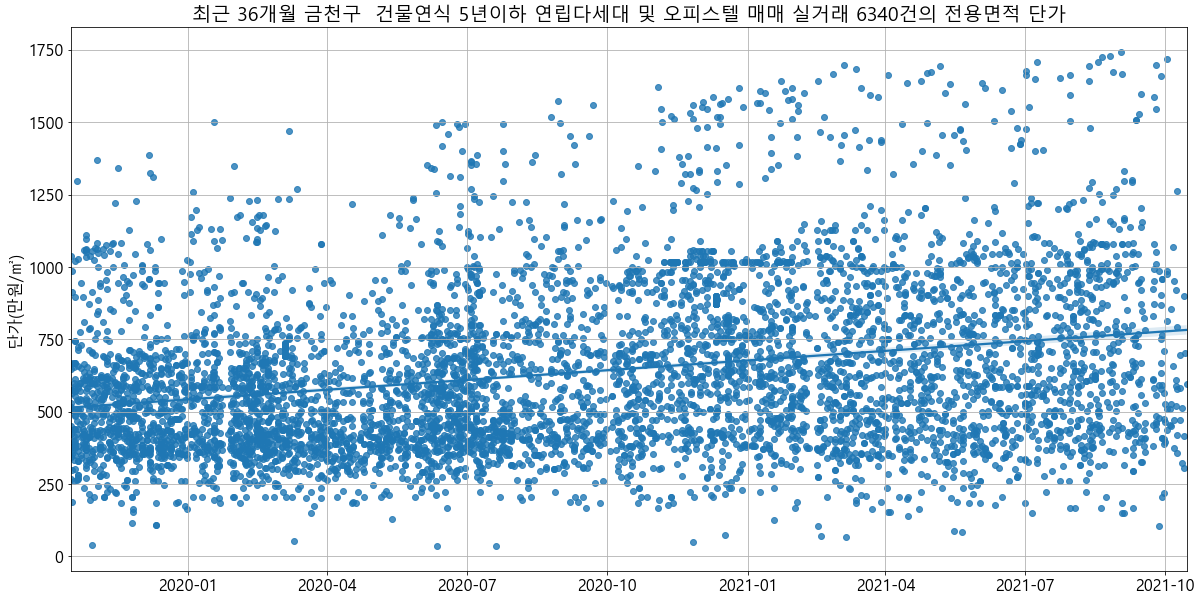

In [41]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [42]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

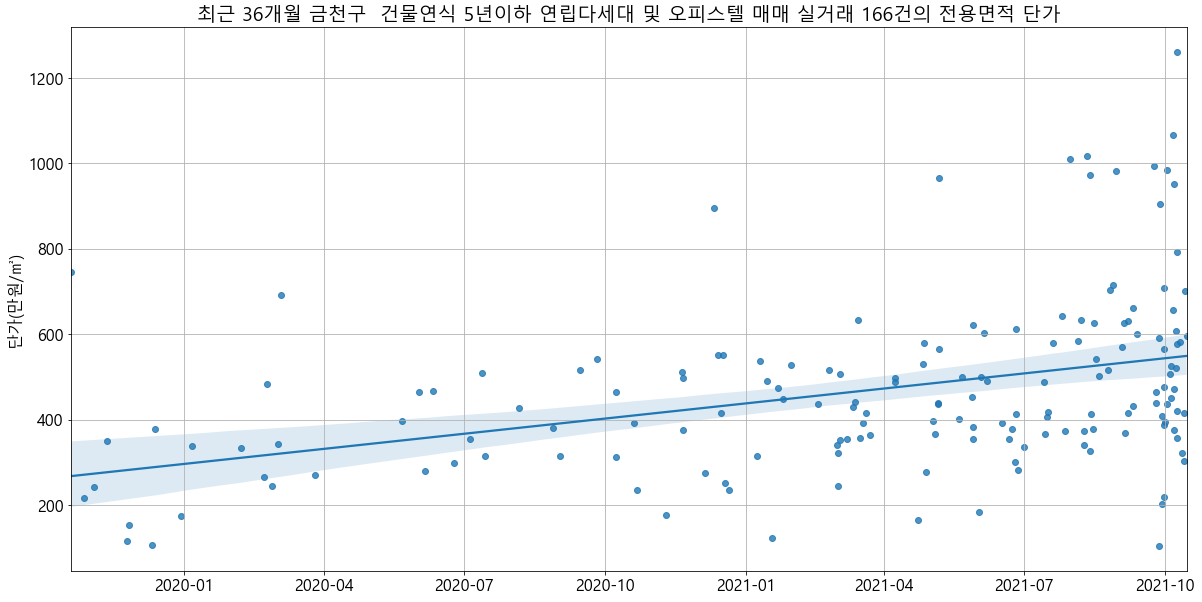

In [43]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [44]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [45]:
target_df2 = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(2402, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
222573,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,16,2021,전세,0,2021-08-12,1146.788991,0,아파트,금천구,가산동,N
222574,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,15,2021,전세,0,2021-08-28,1146.788991,0,아파트,금천구,가산동,N
222575,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,13,2021,전세,0,2021-08-13,1077.586207,0,아파트,금천구,가산동,N
222576,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,15,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N
222577,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,16,2021,전세,0,2021-08-20,1077.586207,0,아파트,금천구,가산동,N


In [46]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'금천구  계약날짜기준 건물연식 5년이하 연립다세대 및 오피스텔 매매 실거래 2402건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

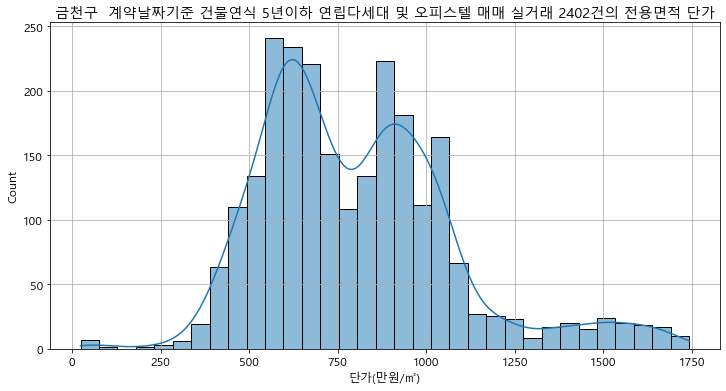

In [47]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [48]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [49]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [50]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [51]:
concat_df = pd.concat([target_df2])

In [52]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [53]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [54]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '지수적용날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(125, 21)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
0,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.08,15000,15,2021,전세,0,2021-08-28,1146.788991,0,아파트,금천구,가산동,N,지수없음,1146.788991,지수없음,1004.431886,1004.431886
1,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),13.92,15000,15,2021,전세,0,2021-09-24,1077.586207,0,아파트,금천구,가산동,N,지수없음,1077.586207,지수없음,1004.431886,1004.431886
2,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),16.61,16500,12,2021,전세,0,2021-09-24,993.377483,0,아파트,금천구,가산동,N,지수없음,993.377483,지수없음,1004.431886,1004.431886
3,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),19.89,18500,17,2021,전세,0,2021-08-20,930.115636,0,아파트,금천구,가산동,N,지수없음,930.115636,지수없음,1004.431886,1004.431886
4,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),21.16,18500,17,2021,전세,0,2021-08-21,874.291115,0,아파트,금천구,가산동,N,지수없음,874.291115,지수없음,1004.431886,1004.431886


In [55]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df.head()

(26, 21)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
4,서울특별시 금천구 가산동 139-14,디지털로 209,(139-14),21.16,18500,17,2021,전세,0,2021-08-21,874.291115,0,아파트,금천구,가산동,N,지수없음,874.291115,지수없음,1004.431886,1004.431886
6,서울특별시 금천구 가산동 139-15,디지털로 207,G밸리 페트라 힐스,27.52,28000,5,2020,전세,1,2021-08-11,1017.441860,1,아파트,금천구,가산동,N,지수없음,1017.441860,지수없음,1053.779070,1053.779070
10,서울특별시 금천구 가산동 140-36,디지털로12길 15,비즈트위트바이올렛5차,30.37,23500,15,2014,매매,5,2019-10-22,773.789924,7,아파트,금천구,가산동,N,109.336,935.411353,2021년 07월,807.965494,987.181973
13,서울특별시 금천구 가산동 140-9,가산로 147,가산지웰에스테이트,16.26,12000,14,2013,전세,5,2018-10-30,738.007380,8,아파트,금천구,가산동,N,105.728,922.599968,2021년 07월,792.275227,1004.525344
14,서울특별시 금천구 가산동 141-2,남부순환로 1266,가산양우내안에애플,12.04,10500,18,2013,전세,5,2018-12-27,872.093023,8,아파트,금천구,가산동,N,104.488,1103.161618,2021년 07월,872.093023,1103.161618


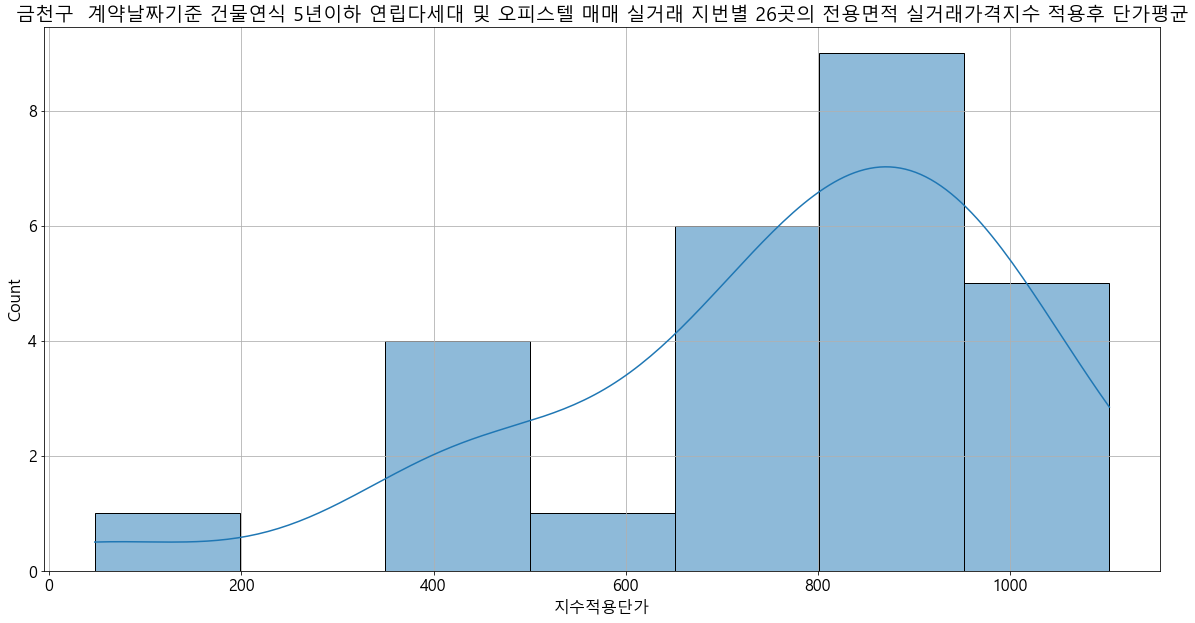

In [56]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [57]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [58]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),지수적용날짜,지수적용단가,부동산유형
0,서울특별시 금천구 가산동 139-14,(139-14),2021,21.16,17,2021-08-21,874.291115,지수없음,874.291115,아파트
1,서울특별시 금천구 가산동 139-15,G밸리 페트라 힐스,2020,27.52,5,2021-08-11,1017.441860,지수없음,1017.441860,아파트
2,서울특별시 금천구 가산동 140-36,비즈트위트바이올렛5차,2014,30.37,15,2019-10-22,773.789924,2021년 07월,935.411353,아파트
3,서울특별시 금천구 가산동 140-9,가산지웰에스테이트,2013,16.26,14,2018-10-30,738.007380,2021년 07월,922.599968,아파트
4,서울특별시 금천구 가산동 141-2,가산양우내안에애플,2013,12.04,18,2018-12-27,872.093023,2021년 07월,1103.161618,아파트


In [59]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)